In [1]:
import numpy as np
import pandas as pd 
from keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os

In [2]:
FAST_RUN = False
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

In [3]:
filenames = os.listdir("data/train/")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'shag':
        categories.append(1)
    elif category == 'razor':
        categories.append(0)
    else:
        categories.append(2)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [4]:
df

,filename,category
0,gull.98.jpeg,2
1,shag.137.jpeg,1
2,shag.80.jpeg,1
3,shag.202.jpeg,1
4,shag.166.jpeg,1
...,...,...
795,gull.155.jpeg,2
796,razor.107.jpeg,0
797,gull.285.jpeg,2
798,gull.218.jpeg,2


In [5]:
df.category.value_counts()

1    282
0    270
2    248
Name: category, dtype: int64

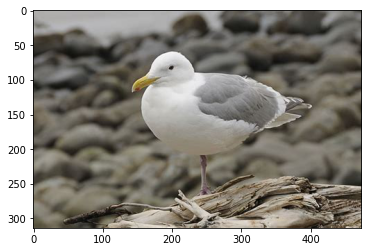

In [6]:
sample = random.choice(filenames)
image = load_img("data/train/" + sample)
plt.imshow(image)

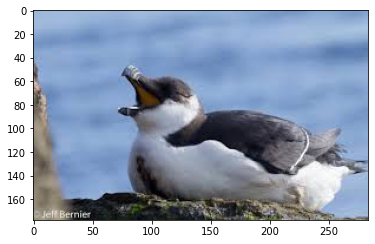

In [7]:
sample = random.choice(filenames)
image = load_img("data/train/" + sample)
plt.imshow(image)

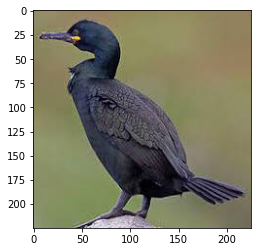

In [11]:
sample = random.choice(filenames)
image = load_img("data/train/" + sample)
plt.imshow(image)

In [12]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax')) 

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 61, 61, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0

In [13]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [14]:
earlystop = EarlyStopping(patience=10)

In [15]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [16]:
callbacks = [earlystop, learning_rate_reduction]

In [17]:
df["category"] = df["category"].replace({0: 'razor', 1: 'shag', 2: 'gull'}) 

In [18]:
df

,filename,category
0,gull.98.jpeg,gull
1,shag.137.jpeg,shag
2,shag.80.jpeg,shag
3,shag.202.jpeg,shag
4,shag.166.jpeg,shag
...,...,...
795,gull.155.jpeg,gull
796,razor.107.jpeg,razor
797,gull.285.jpeg,gull
798,gull.218.jpeg,gull


In [19]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

In [20]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15

In [21]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

In [22]:
train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "data/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 640 validated image filenames belonging to 3 classes.


In [23]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "data/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 160 validated image filenames belonging to 3 classes.


In [24]:
example_df = train_df.sample(n=1).reset_index(drop=True)

In [25]:
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    "data/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


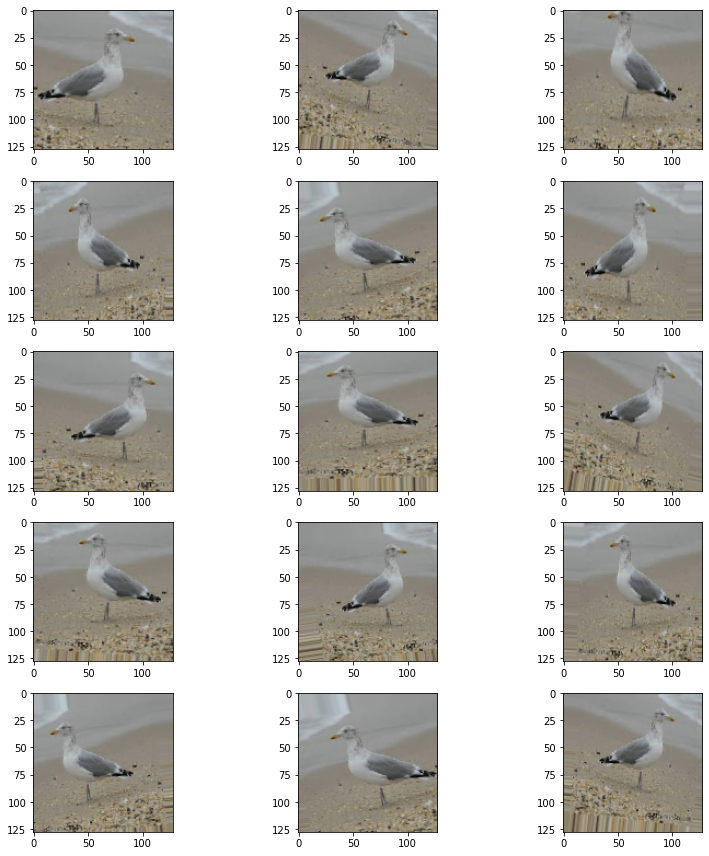

In [26]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

In [27]:
epochs=3 if FAST_RUN else 50
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

/home/admin2/anaconda3/lib/python3.7/site-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
42/42 [==============================] - 65s 818ms/step - loss: 1.9141 - accuracy: 0.5031 - val_loss: 3.0223 - val_accuracy: 0.2867
Epoch 2/50
42/42 [==============================] - 32s 755ms/step - loss: 1.3688 - accuracy: 0.5782 - val_loss: 1.7891 - val_accuracy: 0.2933
Epoch 3/50
42/42 [==============================] - 29s 687ms/step - loss: 1.1088 - accuracy: 0.5931 - val_loss: 2.3919 - val_accuracy: 0.3133
Epoch 4/50
42/42 [==============================] - 27s 639ms/step - loss: 0.8818 - accuracy: 0.6813 - val_loss: 1.3079 - val_accuracy: 0.5000
Epoch 5/50
42/42 [==============================] - 27s 638ms/step - loss: 1.1110 - accuracy: 0.6236 - val_loss: 1.9268 - val_accuracy: 0.4133
Epoch 6/50
42/42 [==============================] - 27s 641ms/step - loss: 0.7955 - accuracy: 0.6914 - val_loss: 2.1144 - val_accuracy: 0.5000

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 7/50
42/42 [==============================] - 27s 645ms

In [28]:
model.save_weights("bird_model.h5")

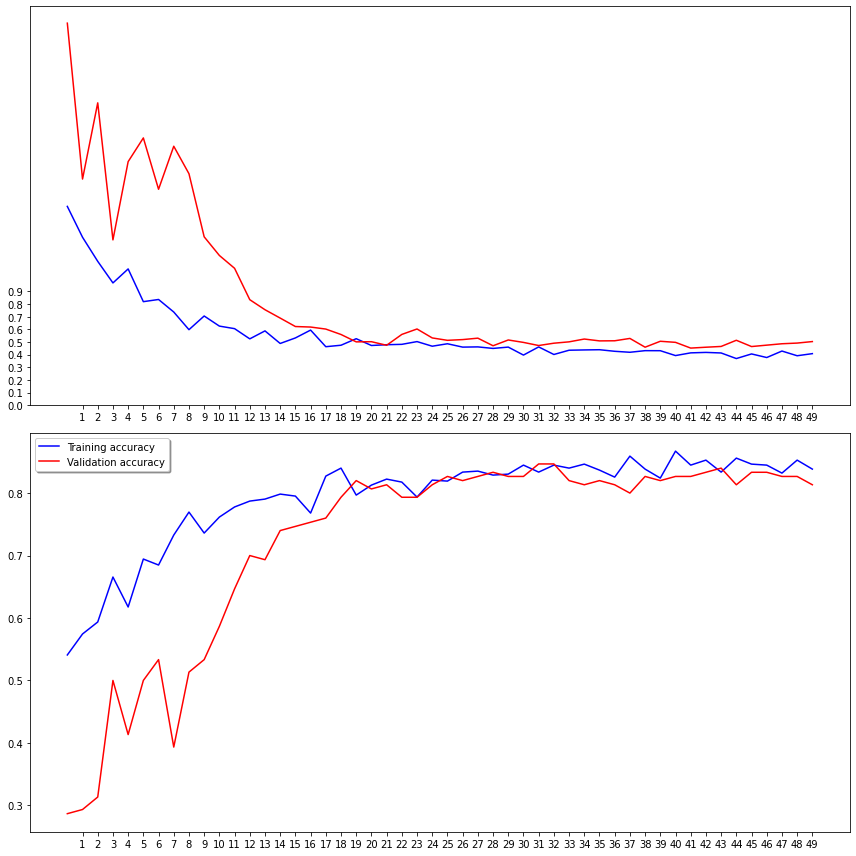

In [29]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()


In [56]:
test_filenames = os.listdir("data/extra")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

In [57]:
test_df

,filename
0,gull.17.jpeg
1,razor.12.jpeg
2,gull.68.jpeg
3,shag.46.jpeg
4,razor.34.jpeg
5,shag.42.jpeg
6,razor.13.jpeg
7,razor.65.jpeg
8,shag.72.jpeg
9,gull.87.jpeg


In [58]:
filenames = os.listdir("data/extra/")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'shag':
        categories.append(1)
    elif category == 'razor':
        categories.append(0)
    else:
        categories.append(2)

test_df = pd.DataFrame({
    'filename': filenames,
    'y_true': categories
})

In [59]:
test_df

,filename,y_true
0,gull.17.jpeg,2
1,razor.12.jpeg,0
2,gull.68.jpeg,2
3,shag.46.jpeg,1
4,razor.34.jpeg,0
5,shag.42.jpeg,1
6,razor.13.jpeg,0
7,razor.65.jpeg,0
8,shag.72.jpeg,1
9,gull.87.jpeg,2


In [62]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "data/extra", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 20 validated image filenames.


In [63]:
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))

In [64]:
test_df['y_pred'] = np.argmax(predict, axis=-1)

In [65]:
test_df

,filename,y_true,y_pred
0,gull.17.jpeg,2,2
1,razor.12.jpeg,0,0
2,gull.68.jpeg,2,2
3,shag.46.jpeg,1,2
4,razor.34.jpeg,0,1
5,shag.42.jpeg,1,1
6,razor.13.jpeg,0,0
7,razor.65.jpeg,0,0
8,shag.72.jpeg,1,1
9,gull.87.jpeg,2,2


In [66]:
test_df.y_pred.value_counts()

2    11
1     5
0     4
Name: y_pred, dtype: int64

In [68]:
from sklearn.metrics import accuracy_score
accuracy_score(test_df['y_true'],test_df['y_pred'])

0.65

In [72]:
from sklearn.metrics import confusion_matrix
confusion_matrix(test_df['y_true'],test_df['y_pred'])   

array([[3, 2, 1],
       [0, 3, 3],
       [1, 0, 7]])

In [52]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)

In [53]:
test_df['category'] = test_df['category'].replace({ 'shag': 1, 'razor': 0,'gull':2 })

In [54]:
test_df

,filename,category
0,gull3.jpeg,2
1,razor338.jpeg,0
2,razor303.jpeg,1
3,razor332.jpeg,0
4,shag338.jpeg,1
...,...,...
145,gull24.jpeg,2
146,shag309.jpeg,1
147,gull42.jpeg,2
148,razor330.jpeg,0


<AxesSubplot:>

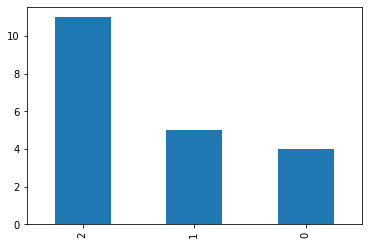

In [73]:
test_df['y_pred'].value_counts().plot.bar()

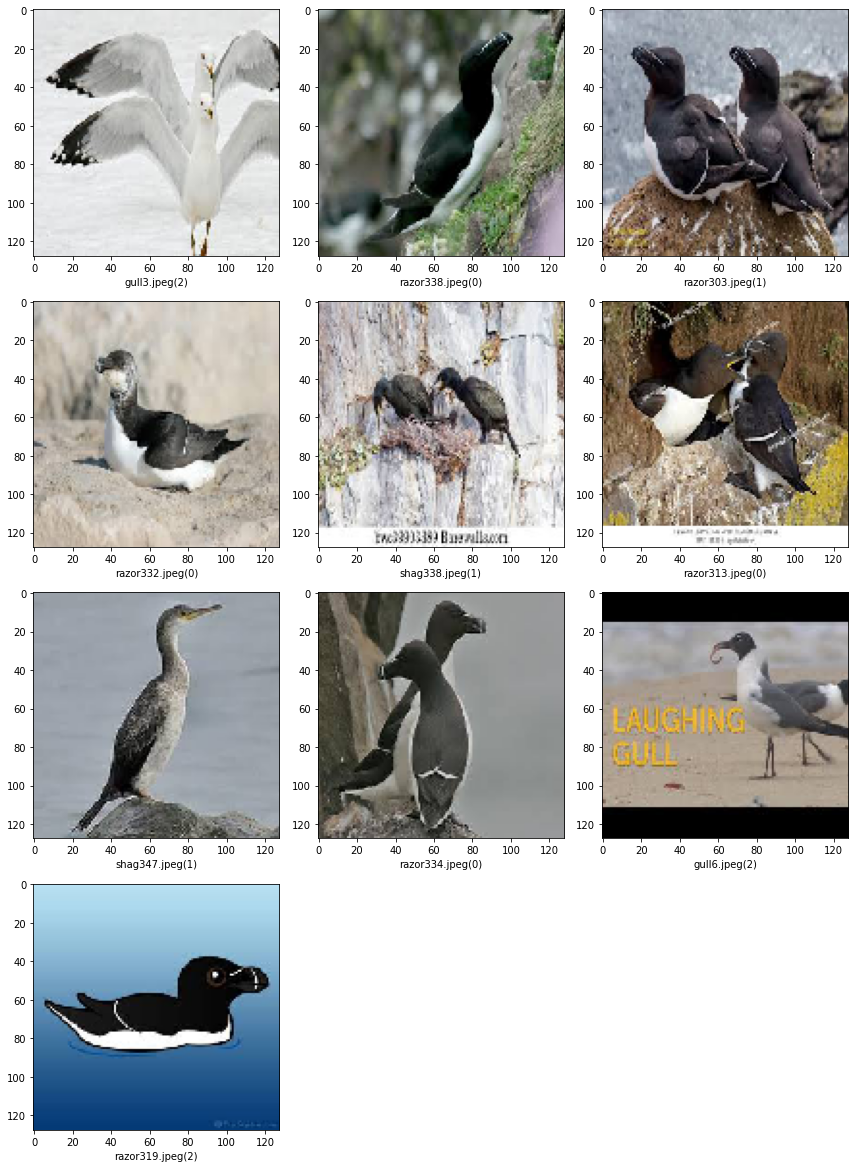

In [63]:
sample_test = test_df.head(10)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("data/test/"+filename, target_size=IMAGE_SIZE)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()
